# Introduction

In this notebook we will be exploring and creating a deep learning model using the tensorflow dataset, fashion_mnist. This dataset consists of a training set of 60,000 samples and test set of 10,000 samples. These samples are in a 28x28 greyscale image associated with 1 of 10 classes. I will be creating a model to predict the class.

In [40]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from collections import Counter
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [21]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [22]:
len(X_train)

60000

In [23]:
len(X_test)

10000

In [25]:
input_dim = 784  # 28*28
output_dim = nb_classes = 10
nb_epoch = 20

X_train = X_train.reshape(60000, input_dim)
X_test = X_test.reshape(10000, input_dim)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
Counter(y_train)

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

The training dataset is perfectly balanced

In [8]:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Models

In [27]:
model = Sequential()
# our first dense layer
model.add(Dense(128, input_shape=(784,), activation="relu"))
# our second dense layer
model.add(Dense(64, activation="relu"))
# last layer is the output layer.
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

# setting verbose=1 prints out some results after each epoch
model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
469/469 [==============================] - 0s 650us/step - loss: 1.1322 - accuracy: 0.6499
Epoch 2/20
469/469 [==============================] - 0s 639us/step - loss: 0.6597 - accuracy: 0.7823
Epoch 3/20
469/469 [==============================] - 0s 656us/step - loss: 0.5683 - accuracy: 0.8105
Epoch 4/20
469/469 [==============================] - 0s 680us/step - loss: 0.5231 - accuracy: 0.8230
Epoch 5/20
469/469 [==============================] - 0s 637us/step - loss: 0.4966 - accuracy: 0.8284
Epoch 6/20
469/469 [==============================] - 0s 641us/step - loss: 0.4763 - accuracy: 0.8349
Epoch 7/20
469/469 [==============================] - 0s 643us/step - loss: 0.4626 - accuracy: 0.8389
Epoch 8/20
469/469 [==============================] - 0s 650us/step - loss: 0.4505 - accuracy: 0.8425
Epoch 9/20
469/469 [==============================] - 0s 639us/step - loss: 0.4404 - accuracy: 0.8469
Epoch 10/20
469/469 [==============================] - 0s 643us/step - loss: 0.432

In [31]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.4274953007698059
Test accuracy: 0.8501999974250793


In [32]:
model = Sequential()
model.add(Dense(128, input_shape=(784,), activation="tanh"))
model.add(Dense(64, activation="tanh"))
model.add(Dense(10, activation="softmax"))
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

# setting verbose=1 prints out some results after each epoch
model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
469/469 [==============================] - 0s 701us/step - loss: 1.0312 - accuracy: 0.6813
Epoch 2/20
469/469 [==============================] - 0s 676us/step - loss: 0.6564 - accuracy: 0.7854
Epoch 3/20
469/469 [==============================] - 0s 667us/step - loss: 0.5687 - accuracy: 0.8090
Epoch 4/20
469/469 [==============================] - 0s 712us/step - loss: 0.5235 - accuracy: 0.8198
Epoch 5/20
469/469 [==============================] - 0s 701us/step - loss: 0.4949 - accuracy: 0.8281
Epoch 6/20
469/469 [==============================] - 0s 669us/step - loss: 0.4750 - accuracy: 0.8334
Epoch 7/20
469/469 [==============================] - 0s 669us/step - loss: 0.4596 - accuracy: 0.8390
Epoch 8/20
469/469 [==============================] - 0s 697us/step - loss: 0.4472 - accuracy: 0.8430
Epoch 9/20
469/469 [==============================] - 0s 671us/step - loss: 0.4375 - accuracy: 0.8467
Epoch 10/20
469/469 [==============================] - 0s 671us/step - loss: 0.428

In [33]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.41445592045783997
Test accuracy: 0.8507000207901001


In [34]:
model = Sequential()
# our first dense layer
model.add(Dense(128, input_shape=(784,), activation="sigmoid"))
# our second dense layer
model.add(Dense(64, activation="tanh"))
# last layer is the output layer.
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

# setting verbose=1 prints out some results after each epoch
model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
469/469 [==============================] - 0s 671us/step - loss: 1.7437 - accuracy: 0.5469
Epoch 2/20
469/469 [==============================] - 0s 654us/step - loss: 1.1024 - accuracy: 0.7015
Epoch 3/20
469/469 [==============================] - 0s 654us/step - loss: 0.8779 - accuracy: 0.7357
Epoch 4/20
469/469 [==============================] - 0s 665us/step - loss: 0.7673 - accuracy: 0.7501
Epoch 5/20
469/469 [==============================] - 0s 712us/step - loss: 0.7024 - accuracy: 0.7607
Epoch 6/20
469/469 [==============================] - 0s 682us/step - loss: 0.6596 - accuracy: 0.7696
Epoch 7/20
469/469 [==============================] - 0s 714us/step - loss: 0.6284 - accuracy: 0.7776
Epoch 8/20
469/469 [==============================] - 0s 673us/step - loss: 0.6037 - accuracy: 0.7858
Epoch 9/20
469/469 [==============================] - 0s 679us/step - loss: 0.5835 - accuracy: 0.7936
Epoch 10/20
469/469 [==============================] - 0s 692us/step - loss: 0.566

In [35]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.5035895705223083
Test accuracy: 0.8179000020027161


In [36]:
model = Sequential()
# our first dense layer
model.add(Dense(128, input_shape=(784,), activation="sigmoid"))
# our second dense layer
model.add(Dense(64, activation="sigmoid"))
# last layer is the output layer.
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='sgd', loss='categorical_hinge',
              metrics=['accuracy'])

# setting verbose=1 prints out some results after each epoch
model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
469/469 [==============================] - 0s 688us/step - loss: 1.0435 - accuracy: 0.0968
Epoch 2/20
469/469 [==============================] - 0s 686us/step - loss: 1.0118 - accuracy: 0.1713
Epoch 3/20
469/469 [==============================] - 0s 692us/step - loss: 1.0097 - accuracy: 0.2963
Epoch 4/20
469/469 [==============================] - 0s 703us/step - loss: 1.0079 - accuracy: 0.3957
Epoch 5/20
469/469 [==============================] - 0s 690us/step - loss: 1.0047 - accuracy: 0.4504
Epoch 6/20
469/469 [==============================] - 0s 699us/step - loss: 1.0005 - accuracy: 0.4729
Epoch 7/20
469/469 [==============================] - 0s 701us/step - loss: 0.9999 - accuracy: 0.4981
Epoch 8/20
469/469 [==============================] - 0s 682us/step - loss: 0.9995 - accuracy: 0.5221
Epoch 9/20
469/469 [==============================] - 0s 725us/step - loss: 0.9991 - accuracy: 0.5423
Epoch 10/20
469/469 [==============================] - 0s 690us/step - loss: 0.998

In [37]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.9950706958770752
Test accuracy: 0.6517999768257141


In [38]:
model = Sequential()
# our first dense layer
model.add(Dense(1024, input_shape=(784,), activation="relu"))
# our second dense layer
model.add(Dense(512, activation="sigmoid"))
# our third dense layer
model.add(Dense(256, activation="sigmoid"))
# our fourth dense layer
model.add(Dense(128, activation="sigmoid"))
# our fifth dense layer
model.add(Dense(64, activation="sigmoid"))
# last layer is the output layer.
model.add(Dense(10, activation="sigmoid"))

model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
469/469 [==============================] - 2s 5ms/step - loss: 2.3063 - accuracy: 0.1001
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 2.3016 - accuracy: 0.1090
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 2.3009 - accuracy: 0.1104
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 2.3002 - accuracy: 0.1177
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 2.2995 - accuracy: 0.1250
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 2.2984 - accuracy: 0.1236
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 2.2974 - accuracy: 0.1408
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 2.2963 - accuracy: 0.1420
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 2.2949 - accuracy: 0.1681
Epoch 10/20
469/469 [==============================] - 2s 5ms/step - loss: 2.2934 - accuracy: 0.1800

In [39]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 2.0602667331695557
Test accuracy: 0.34630000591278076


In [37]:
model = Sequential()
# our first dense layer
model.add(Dense(1024, input_shape=(784,), activation="relu"))
# our second dense layer
model.add(Dense(512, activation="relu"))
# our third dense layer
model.add(Dense(256, activation="relu"))
# our fourth dense layer
model.add(Dense(128, activation="relu"))
# our fifth dense layer
model.add(Dense(64, activation="relu"))
# last layer is the output layer.
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

model_history=model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 1.0845 - accuracy: 0.6671
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.5930 - accuracy: 0.7953
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.5122 - accuracy: 0.8202
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.4709 - accuracy: 0.8337
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.4400 - accuracy: 0.8444
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.4203 - accuracy: 0.8515
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.4026 - accuracy: 0.8569
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3883 - accuracy: 0.8643
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3773 - accuracy: 0.8667
Epoch 10/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3680 - accuracy: 0.8690

In [31]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.3600456416606903
Test accuracy: 0.8682000041007996


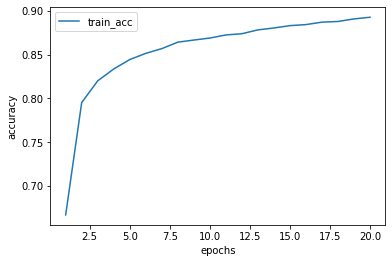

In [41]:
epochs = model_history.params['epochs']
x = [i for i in range(1,epochs+1)]
acc = model_history.history['accuracy']
plt.plot(x, acc, label="train_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

# Discussion

After training various deep learning models, the most optimal model is the last one with 5 Dense layers with activation = 'relu'. This model gives an accuracy of .87. We can also see from the epoch vs accuracy graph that there is only moderate improvement in accuracy after 7 epochs. Reducing this to 10 epochs will yield a more efficient model.